<a href="https://colab.research.google.com/github/Alex-5551/Alex-5551/blob/main/cataract.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import files
uploaded = files.upload()

Saving cataract.zip to cataract.zip


In [9]:
 ##import relevant libraries
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras import layers, Model
from tensorflow.keras.models import Sequential

import cv2
import os
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications import ResNet50
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

In [3]:
## unzip file
import zipfile
import os

zip_path = 'cataract.zip'

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall('cataract_data')


os.listdir('cataract_data')


['eye_cataracwithlabels']

In [4]:
## directories
base_dir =  "/content/cataract_data/eye_cataracwithlabels"
train_dir = os.path.join(base_dir, 'train')
val_dir = os.path.join(base_dir, 'valid')
test_dir = os.path.join(base_dir, 'test')

##Image Visualization



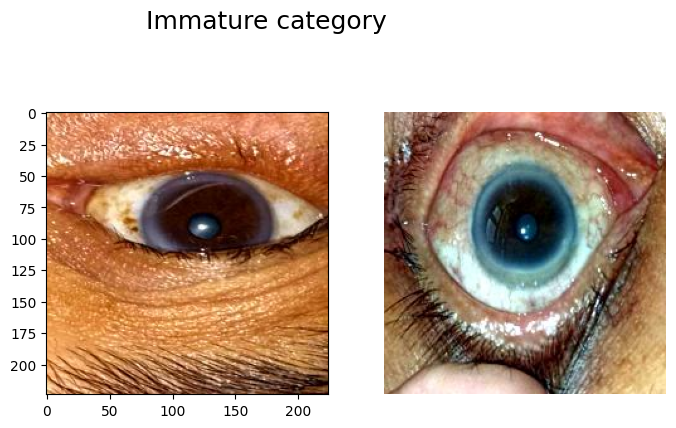

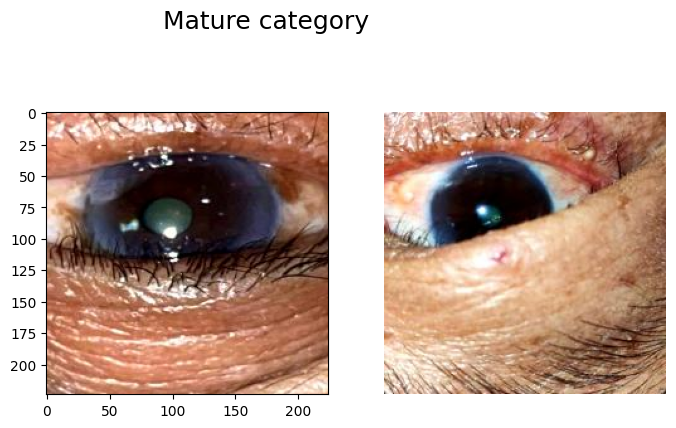

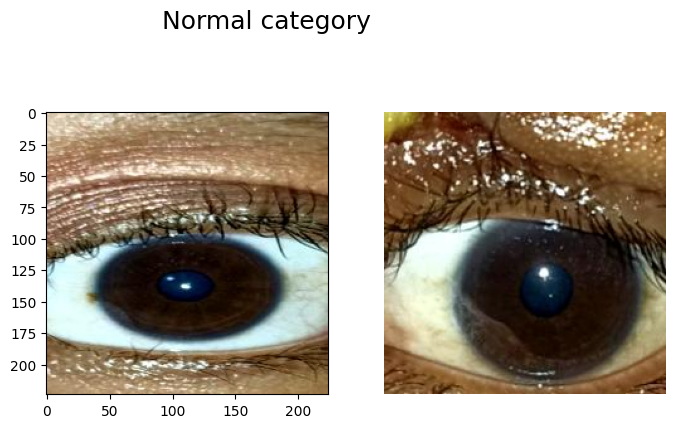

In [5]:
categories = ["Immature", "Mature", "Normal"]

for category in categories:
  path = os.path.join(val_dir, category)
  images = os.listdir(path)

  fig,ax = plt.subplots(1,2,figsize=(8,8))
  fig.suptitle(f"{category} category", fontsize = 18, x= 0.4, y= 0.8)

  for i in range(2):
    img = images[np.random.randint(2, len(images))]
    img_path = os.path.join(path,img)
    img_array = cv2.imread(img_path)
    img_convert = cv2.cvtColor(img_array, cv2.COLOR_BGR2RGB)
    ax[i].imshow(img_convert)
    ax[1].axis("off")

In [6]:
# counts the number of categories in each file
def count_images(directory):
  for category in categories:
    path = os.path.join(directory, category)
    images = os.listdir(path)
    count = len(images)
    print(f"{category}:{count}")

print(f" Train set count")
count_images(train_dir)
print(f"\nValidation set count")
count_images(val_dir)
print(f"\nTest set count")
count_images(test_dir)

 Train set count
Immature:1125
Mature:1283
Normal:1304

Validation set count
Immature:387
Mature:436
Normal:414

Test set count
Immature:368
Mature:421
Normal:448


##CNN MODEL (RESNET50)
split data

In [20]:
train_ds = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    seed=123,
    verbose = True,
    image_size = (224,224),
    batch_size = 32
)

test_ds = tf.keras.utils.image_dataset_from_directory(
    test_dir,
    seed=123,
    verbose = True,
    image_size = (224,224),
    batch_size = 32,
    shuffle = False
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    val_dir,
    seed=123,
    verbose = True,
    image_size = (224,224),
    batch_size = 32,
    shuffle = False
)

Found 3712 files belonging to 3 classes.
Found 1237 files belonging to 3 classes.
Found 1237 files belonging to 3 classes.


In [21]:
# instantiate the RESNET50 MODEL
pretrained_model = ResNet50(weights = "imagenet",include_top = False, input_shape = (224,224,3))

pretrained_model.trainable = False

In [22]:
# build on top of the pretrained model
x = pretrained_model.output
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(64, activation='relu')(x)
x = layers.Dense(128, activation='relu')(x)
output = layers.Dense(3, activation='softmax')(x)

model = Model(inputs=pretrained_model.input, outputs=output)

# Compile the model
model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

# Train the model
model.fit(train_ds, validation_data=val_ds, epochs=3)


Epoch 1/3
116/116 ━━━━━━━━━━━━━━━━━━━━ 28s 151ms/step - accuracy: 0.6437 - loss: 0.7542 - val_accuracy: 0.8787 - val_loss: 0.2890
Epoch 2/3
116/116 ━━━━━━━━━━━━━━━━━━━━ 12s 108ms/step - accuracy: 0.9430 - loss: 0.1871 - val_accuracy: 0.9766 - val_loss: 0.0803
Epoch 3/3
116/116 ━━━━━━━━━━━━━━━━━━━━ 23s 126ms/step - accuracy: 0.9871 - loss: 0.0573 - val_accuracy: 0.9895 - val_loss: 0.0396


##Model Evaluation

In [23]:
test_loss, test_acc = model.evaluate(test_ds)
print(f"Test Accuracy: {test_acc:.2f}")


39/39 ━━━━━━━━━━━━━━━━━━━━ 3s 80ms/step - accuracy: 0.9955 - loss: 0.0424
Test Accuracy: 0.99


39/39 ━━━━━━━━━━━━━━━━━━━━ 10s 168ms/step
              precision    recall  f1-score   support

    Immature       0.98      0.99      0.99       368
      Mature       1.00      1.00      1.00       421
      Normal       1.00      0.99      1.00       448

    accuracy                           0.99      1237
   macro avg       0.99      0.99      0.99      1237
weighted avg       0.99      0.99      0.99      1237



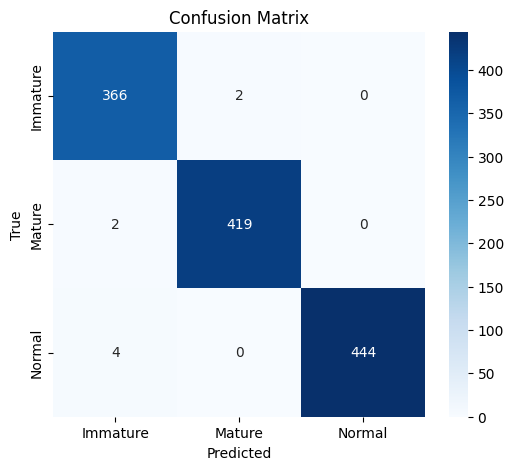

In [24]:
# Get true and predicted labels
y_true = np.concatenate([y for x, y in test_ds], axis=0)
y_pred = np.argmax(model.predict(test_ds), axis=1)

# Classification report
print(classification_report(y_true, y_pred, target_names=test_ds.class_names))

# Confusion matrix
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=test_ds.class_names, yticklabels=test_ds.class_names)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()


In [25]:
##save model
model.save("cataract_model.h5")


## Prediction

In [36]:
from tensorflow.keras.preprocessing import image
import numpy as np

# Load the image and preprocess it
def preprocess_image(img_path, img_height, img_width):
    img = image.load_img(img_path, target_size=(img_height, img_width))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
    print(img_array.shape)
    return img_array

img_path = "/content/cataract_data/eye_cataracwithlabels/train/Immature/Immature (1000).jpg"

# Preprocess the image
img_array = preprocess_image(img_path, 224, 224)

# Predict
prediction = model.predict(img_array)
predicted_class = test_ds.class_names[np.argmax(prediction)]
print("Predicted Class:", predicted_class)

(1, 224, 224, 3)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step
Predicted Class: Immature
